# Pipeline Final: sklearn.resample, Comparativa de 6 Modelos y Visualización
**Versión Definitiva con Remuestreo de Scikit-learn**

Este notebook implementa el pipeline completo utilizando `sklearn.utils.resample` para el sobremuestreo de las clases minoritarias en el conjunto de entrenamiento.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar y dividir datos
df = pd.read_excel('RespuestasSemillero.xlsx')
features = ['Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q23', 'Q25', 'Q30', 'Q31']
X = df[features]
y_placeholder = df['Q6']
X_train, X_test, _, _ = train_test_split(X, y_placeholder, test_size=0.2, random_state=42)

# Pipeline de Clustering y generación de etiquetas
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns
preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)])
clustering_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('clusterer', GaussianMixture(n_components=3, random_state=42))])
clustering_pipeline.fit(X_train)
y_train = clustering_pipeline.predict(X_train)
y_test = clustering_pipeline.predict(X_test)

# Preprocesar datos y aplicar resample manualmente
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
train_processed_df = pd.DataFrame(X_train_processed)
train_processed_df['cluster'] = y_train
majority_class_label = train_processed_df['cluster'].value_counts().idxmax()
majority_df = train_processed_df[train_processed_df['cluster'] == majority_class_label]
n_majority = len(majority_df)
resampled_dfs = [majority_df]
for label in train_processed_df['cluster'].unique():
    if label != majority_class_label:
        minority_df = train_processed_df[train_processed_df['cluster'] == label]
        resampled_minority = resample(minority_df, replace=True, n_samples=n_majority, random_state=42)
        resampled_dfs.append(resampled_minority)
resampled_train_df = pd.concat(resampled_dfs)
X_train_resampled = resampled_train_df.drop('cluster', axis=1).values
y_train_resampled = resampled_train_df['cluster'].values
print('Distribución de clases en Train (después de resample):', np.bincount(y_train_resampled))

Distribución de clases en Train (después de resample): [34 34 34]


### Entrenamiento y Evaluación Comparativa (con sklearn.resample)

In [2]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=150),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'SVC': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'MLP Classifier': MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(50,))
}

f1_scores_dict = {}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed)
    print(f'--- Resultados para {name} ---')
    print(classification_report(y_test, y_pred))
    f1_scores_dict[name] = f1_score(y_test, y_pred, average='weighted')

--- Resultados para Logistic Regression ---
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.47      0.64        15
           2       0.00      0.00      0.00         0

    accuracy                           0.53        17
   macro avg       0.47      0.49      0.40        17
weighted avg       0.93      0.53      0.63        17

--- Resultados para Random Forest ---
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.53      0.70        15
           2       0.00      0.00      0.00         0

    accuracy                           0.59        17
   macro avg       0.47      0.51      0.42        17
weighted avg       0.93      0.59      0.68        17



c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

--- Resultados para XGBoost ---
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.60      0.75        15
           2       0.00      0.00      0.00         0

    accuracy                           0.65        17
   macro avg       0.50      0.53      0.47        17
weighted avg       0.94      0.65      0.74        17

--- Resultados para SVC ---
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.53      0.70        15
           2       0.00      0.00      0.00         0

    accuracy                           0.59        17
   macro avg       0.47      0.51      0.42        17
weighted avg       0.93      0.59      0.68        17

--- Resultados para Naive Bayes ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.73

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

### Gráfica Comparativa de Rendimiento (F1-Score)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11736\2110812247.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='F1-Score', y='Model', data=f1_df, palette='plasma')


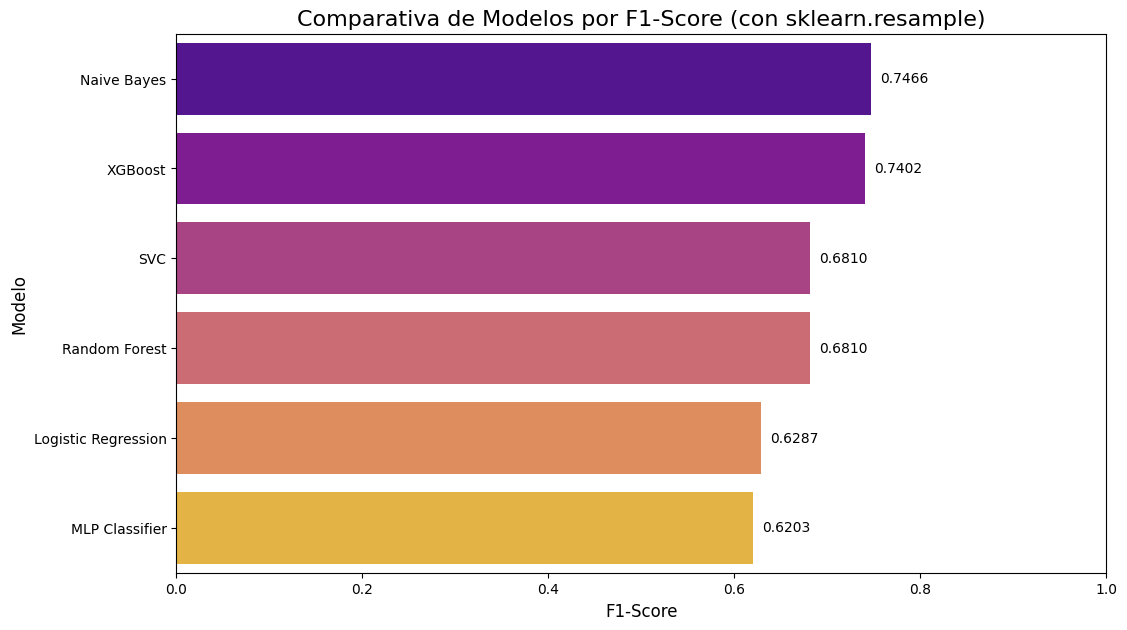

In [3]:
f1_df = pd.DataFrame(list(f1_scores_dict.items()), columns=['Model', 'F1-Score']).sort_values('F1-Score', ascending=False)
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='F1-Score', y='Model', data=f1_df, palette='plasma')
plt.title('Comparativa de Modelos por F1-Score (con sklearn.resample)', fontsize=16)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
plt.xlim(0, 1.0)
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01, p.get_y() + p.get_height()/2. + 0.0, f'{width:.4f}', ha='left', va='center')
plt.show()